![Featured Image](https://i.imgur.com/XzTAemQ.jpg)

**1.0: Dependencies & Configuration**

In [14]:
import os, random, gc, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import keras_preprocessing.image
import tensorflow.keras.backend as k
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from PIL import Image
from google.colab import drive

# Configuration
%matplotlib inline

is_pretrained = True # Trained with locked base_model
keep_training = False # Additional unlocked layers
batch_size = 39
width = 640
height = 480
learning_rate = 1e-2
proj_dir = './gdrive/My Drive/Colab Notebooks/mmwml_w4_xray_pneumonia_detector'

# Google Drive
drive.mount('/content/gdrive')

print('Tensorflow version: {}'.format(tf.__version__))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Tensorflow version: 1.14.0


In [2]:
# Original Dataset from https://data.mendeley.com/datasets/rscbjbr9sj/2

xray_path = '{}/ChestXRay2017.zip'.format(proj_dir).replace(' ', '\\ ')
!unzip $xray_path

Archive:  ./gdrive/My Drive/Colab Notebooks/mmwml_w4_xray_pneumonia_detector/ChestXRay2017.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1647_virus_2848.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person89_bacteria_440.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person35_virus_80.

**1.1: Data Imports**    
We have 5,232 images in our training set and 624 images in our validation set. There are more pneumonia X-Ray images than normal images. These images are varied in size and canvas orientation.

To increase the robustness of our model, we'll add random jitter to the image using ImageDataGenerator's sheer and zoom controls.

In [3]:
def dir_file_count(directory):
  total_files = 0
  for root, dirs, files in os.walk(".", topdown=False):
    total_files += len(list(filter(lambda x: x.endswith('.jpeg'), files)))
  return total_files

def xray_process(im):
  # X-Rays are negative images. Imagenet was trained on normal images.
  im = 255. - im

  # Imagenet tensorflow samples are scaled between -1 (black) and 1 (white)
  # https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  im /= 255.
  im -= .5
  im *= 2.
  return im

target_size = (height, width)
class_mode = 'categorical'
training_dir = './chest_xray/train'
testing_dir = './chest_xray/test'

train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=xray_process)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)

Found 5232 images belonging to 2 classes.


We'll usee a separate generator for the test set which avoids the randomized jitter and horizontal flipping.

In [4]:
test_datagen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  preprocessing_function=xray_process)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    interpolation='bicubic',
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False)

Found 624 images belonging to 2 classes.


In [5]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1.93921423 0.6737059 ]


In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = './chest_xray'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  # Ignore .DS_Store files
  image_list = list(filter(lambda x: x.endswith('.jpeg'), image_list))
  return image_list

tr_normal = get_image_set('train', 'NORMAL')
tr_pneumonia = get_image_set('train', 'PNEUMONIA')

te_normal = get_image_set('test', 'NORMAL')
te_pneumonia = get_image_set('test', 'PNEUMONIA')

images_normal = tr_normal + te_normal
images_pneumonia = tr_pneumonia + te_pneumonia
images_pneumonia_bacterial = [img for img in images_pneumonia
                              if img.split('/')[-1].split('_')[1] == 'bacteria']
images_pneumonia_viral = [img for img in images_pneumonia
                          if img.split('/')[-1].split('_')[1] == 'virus']

images_full = images_normal + images_pneumonia
images_test = te_normal + te_pneumonia

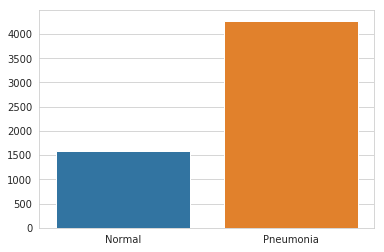

In [7]:
sns.set_style('whitegrid')
sns.barplot(x=['Normal', 'Pneumonia'],
            y=[len(images_normal),
               len(images_pneumonia)])

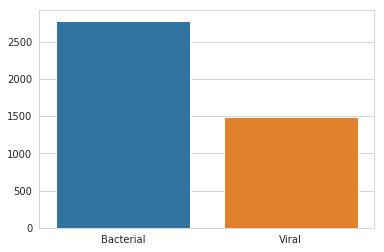

In [8]:
sns.set_style('whitegrid')
sns.barplot(x=['Bacterial', 'Viral'],
            y=[len(images_pneumonia_bacterial),
               len(images_pneumonia_viral)])

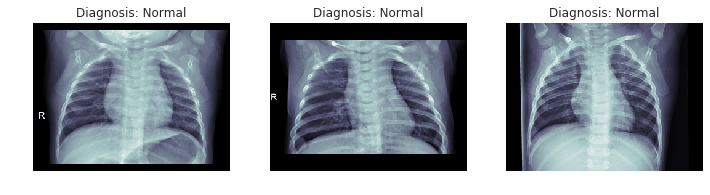

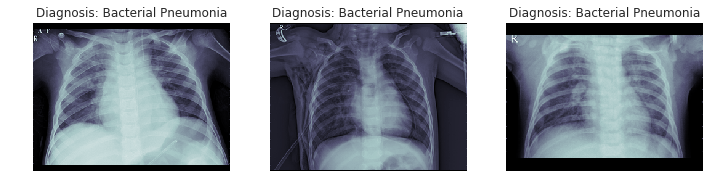

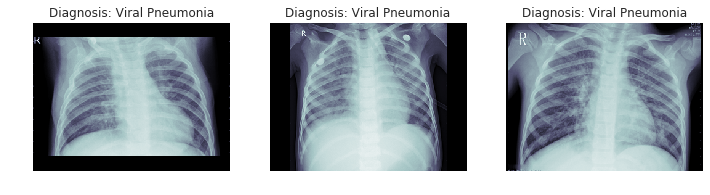

In [9]:
def get_image(path):
  return cv2.imread(path, 0)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_xrays(image_set, image_label,
                      width=width//2, height=height//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
    im = get_resized_image(image_set[i], width, height)[:, :, 0]
    ax[idx%cols].imshow(im, cmap='bone')
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

plot_sample_xrays(images_normal, 'Normal')
plot_sample_xrays(images_pneumonia_bacterial, 'Bacterial Pneumonia')
plot_sample_xrays(images_pneumonia_viral, 'Viral Pneumonia')

**3.0: Model Architecture**    
We'll use transfer learning to bridge the gap between an initial **InceptionV3** model with **imagenet** weights and our target X-Ray processing model. We'll use multiple fully-connected Dense layers with Dropout to reduce overfitting.

# Transfer Learning with InceptionV3
![We need to go deeper.](https://i.imgur.com/XY78lJn.jpg)

![InceptionV3 Architecture](https://i.imgur.com/fQfSNNL.png)

(https://medium.com/@sh.tsang/review-inception-v3-1st-runner-up-image-classification-in-ilsvrc-2015-17915421f77c)

In [0]:
def build_model(optimizer):
  base_model = InceptionV3(weights='imagenet', include_top=False,
                           input_shape=(height, width, 3)) # 311 Layers
  x = base_model.output
  x = Dropout(0.4)(x)
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.4)(x)
  x = Dense(16)(x)
  x = LeakyReLU()(x)
  x = Dropout(0.4)(x)
  p = Dense(len(class_w), activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=p)

  for layer in base_model.layers:
    layer.trainable = False

  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

**3.1: Model Transfer Learning: InceptionV3 -> Chest X-Ray Pneumonia Diagnostic**

In [11]:
# Model Construction

model = build_model(SGD(learning_rate=learning_rate, momentum=0.9))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
87916544/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 239, 319, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 239, 319, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [0]:
# Creates directory, if directory exists removes if remove parameter is True
def create_directory(directory_path, remove=False):
  if remove and os.path.exists(directory_path):
    try:
      shutil.rmtree(directory_path)
      os.mkdir(directory_path)
    except:
      print("Could not remove directory : ", directory_path)
      return False
  else:
    try:
      os.mkdir(directory_path)
    except:
      print("Could not create directory: ", directory_path)
      return False   
  return True

main_model_dir = '{}/models'.format(proj_dir)
m_dir = main_model_dir + '/' + time.strftime('%Y-%m-%d_%H-%M-%S') + '/'
ckp_path = m_dir + 'v_acc-{val_acc:.2f}-v_loss-{val_loss:.2f}.hdf5'
create_directory(m_dir, remove=True)

checkpoint = ModelCheckpoint(ckp_path,
                             monitor='val_acc', 
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=2,
                              cooldown=2,
                              min_lr=1e-10,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

In [0]:
def unlock_layers(num_layers):
  for l in range(311 - num_layers, 311):
      model.layers[l].trainable = True

def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=10,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

if keep_training:
  # After Transfer Learning, let's open up a few layers for continued education.
  unlock_layers(11)
  model.compile(SGD(learning_rate=1e-9, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()

if is_pretrained:
  model.load_weights('{}/v_acc-0.76-v_loss-0.51.hdf5'.format(main_model_dir))

# train_model()

**4.0: Model Validation**    
The accuracy is assessed by a receiver operating characteristics area under the curve (**ROC AUC**) score, an F1 score, and a confusion matrix (True Positive/Negative vs False Positive/Negative).

(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

![AUC Figure](https://i.imgur.com/9qAEpH3.jpg)

> In general, an AUC of 0.5 suggests no discrimination (i.e., ability to diagnose patients with and without the disease or condition based on the test), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 is considered excellent, and more than 0.9 is considered outstanding.

https://www.sciencedirect.com/science/article/pii/S1556086415306043


**4.0: Predictions**    
First, how accurately can human radiologists diagnose pneumonia from an Xray?

In this study, published 2018 in the International Journal of Emergency Medicine:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5845910/ 62 patients were diagnosed with pneumonia by CT. Chest X-Rays had a diagnostic sensitivity for pneumonia (true positive rate) of 73% and a specificity (true negative rate) of 50%, corresponding to a calculated AUC (by trapezoidal rule) of 0.615.

In an article published in 2018 on swarm intelligence and pneumonia detection by CXR, human experts scored a 73% diagnostic accuracy, compared with 82% by radiologists: https://venturebeat.com/2018/09/10/unanimous-ai-achieves-22-more-accurate-pneumonia-diagnoses/

With these values in mind, now, let's see how our model compares using very low-resolution imagery, limited training samples, and a short training period on a single GPU with limited CPU memory. With greater resources, this model would be expected to acheive higher diagnostic accuracy.

In [17]:
vl_score = model.predict_generator(test_generator)

classes = ['Normal', 'Pneumonia']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

      Normal       0.88      0.41      0.56       234
   Pneumonia       0.73      0.97      0.83       390

    accuracy                           0.76       624
   macro avg       0.81      0.69      0.70       624
weighted avg       0.79      0.76      0.73       624

AUC:  0.6905982905982906


**4.1: Prediction Pipeline**

![Data Pipeline](https://i.imgur.com/9TXz5Tk.jpg)

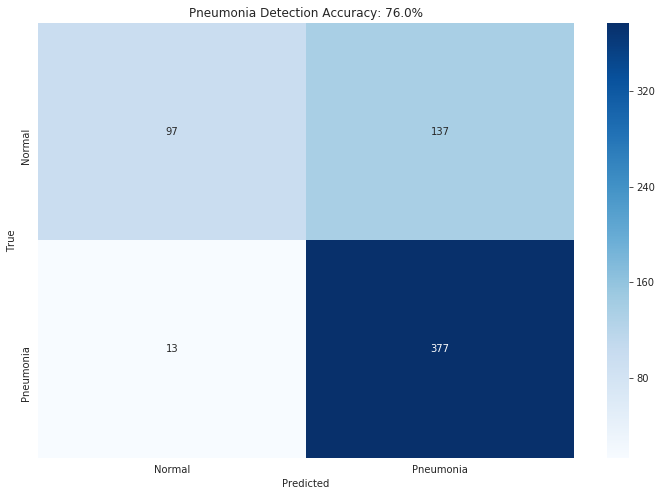

In [20]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Pneumonia Detection Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

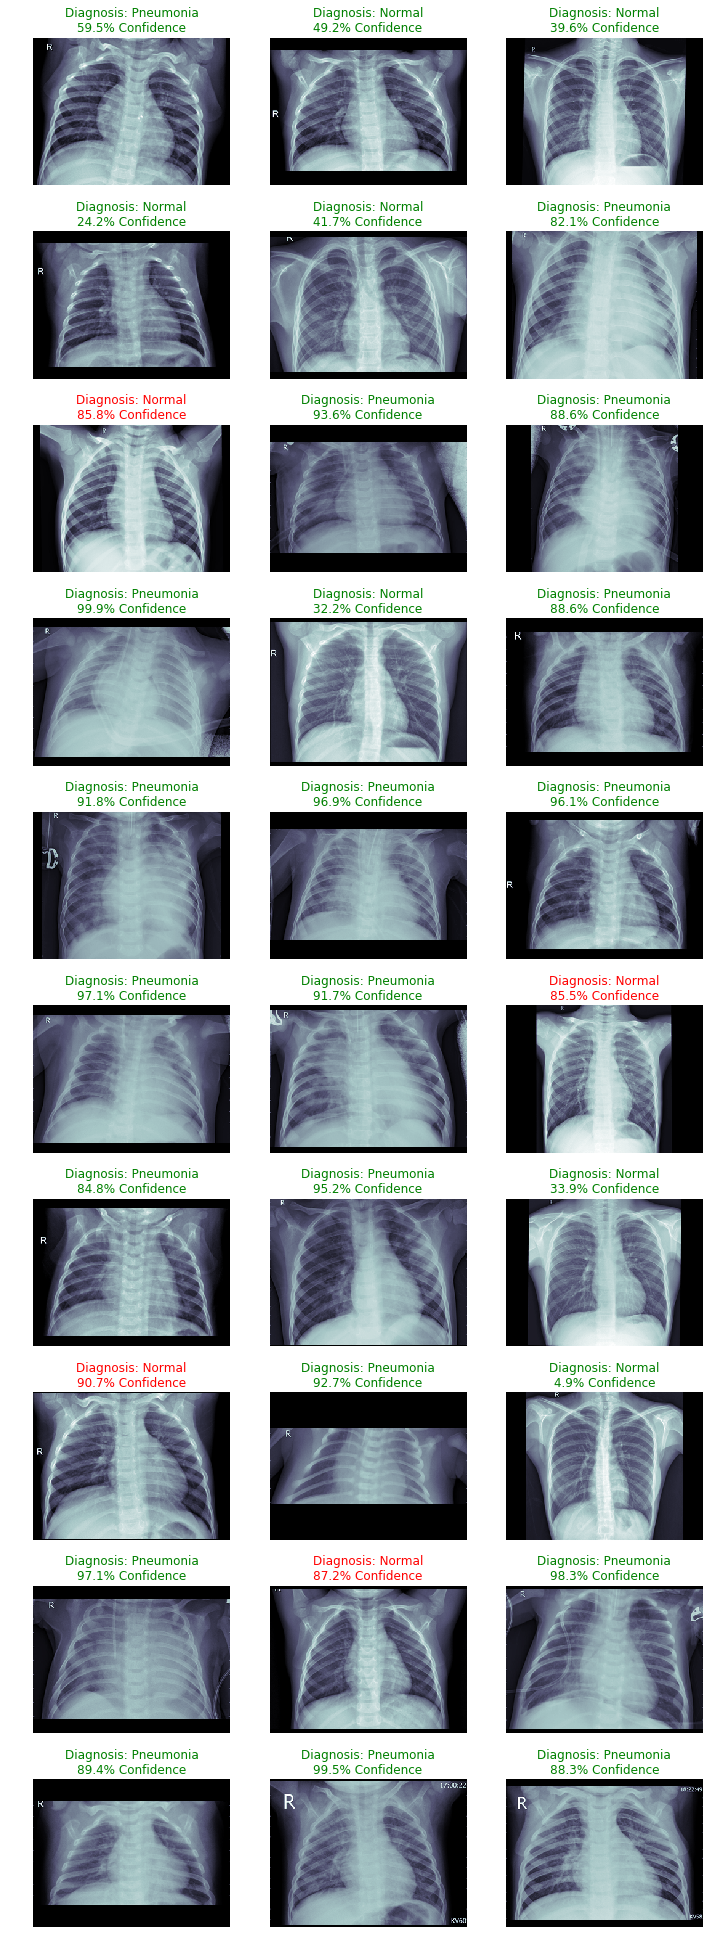

In [19]:
def plot_val_xrays(width=width//2, height=height//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Incorrect diagnosis
    1: 'green' # Correct diagnosis
  }

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == pred else 0
        
    diagnosis_type = 'Pneumonia' if test_generator.classes[i] == 1 else 'Normal'
    diagnosis_conf = vl_score[i][1] * 100.0
    diagnosis = 'Diagnosis: {}\n{:.1f}% Confidence'.format(diagnosis_type,
                                                           diagnosis_conf)

    im = get_resized_image(images_test[i], width, height)[:, :, 0]
    ax[idx//cols,idx%cols].imshow(im, cmap='bone')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_xrays()